In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [135]:
import gc

import pandas as pd
import numpy as np

from xgboost import plot_importance
import matplotlib.pyplot as pyplot
from xgboost.sklearn import XGBClassifier

# from preprocess import preprocess
# from train import train_eval_model

from load import BaseDataLoader
from packager import Packager
from feature_engineer import FeatureEngineer
from cross_val_labo import CrossValLabo

In [4]:
data = BaseDataLoader('/home/dan/Projects/kaggle-ieee-cis-fraud-detection/data').files
trs_train = data['train_transaction']
trs_test = data['test_transaction']
del data
gc.collect()

Loaded tables' types are not converted


0

In [34]:
train_mask, val_mask = Packager.get_train_val_masks(trs_train)

In [233]:
train = trs_train[train_mask]
val = trs_train[val_mask]
feat_cols, label_col = Packager.split_feat_label(train)
X_train = train[feat_cols]
Y_train = train[label_col]
X_val = val[feat_cols]
Y_val = val[label_col]
del train
del val
gc.collect()

0

In [307]:
skip = ['trs_amt_sin', 'trs_amt_scale', 'trs_amt_diff', 'trs_amt_round'] #, 'trs_card_type_dum'
exclude = ['trs_amt_scale', 'trs_amt_round']
fi = FeatureEngineer(skip, exclude)
X_train_prepro = fi.transform(X_train, 'TransactionID', 'train')
X_val_prepro = fi.transform(X_val, 'TransactionID', 'val')

step 0: trs_amt_sin
skipping
step 1: trs_amt_scale
skipping
step 2: trs_amt_diff
skipping
step 3: trs_amt_round
skipping
step 4: trs_card_type_dum
step 0: trs_amt_sin
skipping
step 1: trs_amt_scale
skipping
step 2: trs_amt_diff
skipping
step 3: trs_amt_round
skipping
step 4: trs_card_type_dum
missing card_type_charge card
missing card_type_debit or credit


In [308]:
X_train_prepro

,phase_sin,phase_cos,amt_diff,card_type_charge card,card_type_credit,card_type_debit,card_type_debit or credit,card_type_other,card_comp_american express,card_comp_discover,card_comp_mastercard,card_comp_other,card_comp_visa
TransactionID,,,,,,,,,,,,,
2987000,-0.056763,-0.998535,-0.529060,0,1,0,0,0,0,1,0,0,0
2987001,-0.056824,-0.998535,-0.800624,0,1,0,0,0,0,0,1,0,0
2987002,-0.061523,-0.998047,-0.594373,0,0,1,0,0,0,0,0,0,1
2987003,-0.063599,-0.998047,-0.656248,0,0,1,0,0,0,0,1,0,0
2987004,-0.064087,-0.998047,-0.656248,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483431,-0.870117,0.493164,1.285457,0,0,1,0,0,0,0,1,0,0
3483432,-0.866699,0.499023,1.285457,0,0,1,0,0,0,0,1,0,0
3483433,-0.865234,0.501465,2.116860,0,0,1,0,0,0,0,0,0,1


In [309]:
model = XGBClassifier()
parameters = {
    'nthread':[4], #when use hyperthread, xgboost may become slower
    'objective':['binary:logistic'],
    'learning_rate': [0.6], # from 0.1
    'max_depth': [1, 2], # opti 20 but slow
    'min_child_weight': [40],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8], # from 0.8
    'n_estimators': [1000], #number of trees, change it to 1000 for better results
    'seed': [1337]}

In [310]:
best_parameters_val, score_val, score_train, model = CrossValLabo.optimize_hparams(model, parameters, X_train_prepro, Y_train, X_val_prepro, Y_val)

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] colsample_bytree=0.8, learning_rate=0.6, max_depth=1, min_child_weight=40, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, learning_rate=0.6, max_depth=1, min_child_weight=40, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1337, silent=1, subsample=0.8, total=  39.3s
[CV] colsample_bytree=0.8, learning_rate=0.6, max_depth=2, min_child_weight=40, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.3s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.6, max_depth=2, min_child_weight=40, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1337, silent=1, subsample=0.8, total=  59.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min finished


In [313]:
print(best_parameters_val)
print(score_val)
print(score_train)

{'colsample_bytree': 0.8, 'learning_rate': 0.6, 'max_depth': 1, 'min_child_weight': 40, 'n_estimators': 1000, 'nthread': 6, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
0.6587299824566636
0.6849558227809228


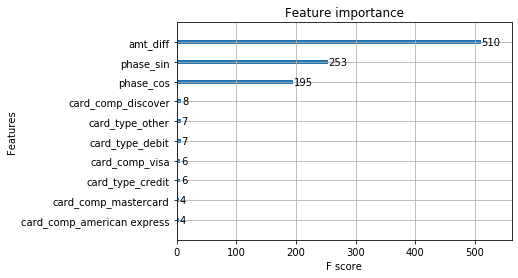

In [314]:
plot_importance(model)